# Objectness Classification Models Analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
import sys
import git
import matplotlib.pyplot as plt
import torch

git_repo = git.Repo(os.getcwd(), search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

## Loading data

In [5]:
sys.path.append(f"{git_root}/objectness_classification/")
from seed import set_seed
sys.path.append(f"{git_root}/objectness_classification/datasets")
from datamodule import ObjnessClsDataModule

home = os.path.expanduser("~")
dataset_dir = os.path.join(home, "Documents/datasets")

set_seed()
iter_counter = 0

dataset = ObjnessClsDataModule(
    dataset_dir=dataset_dir,
    dataset_mode='egohos',
    batch_size=1,
    with_transform=False,
    with_info=True,
)
dataset.setup(stage="test")

dataloader = iter(dataset.test_dataloader()[0])

iter counter: 3
frames shape: torch.Size([1, 3, 224, 224])
label shape: torch.Size([1, 2, 224, 224])
converted frames shape: torch.Size([224, 224, 3])
file name: ('ego4d_1fae6ecb-2ad9-4160-b388-c34e7d018915_1050',)


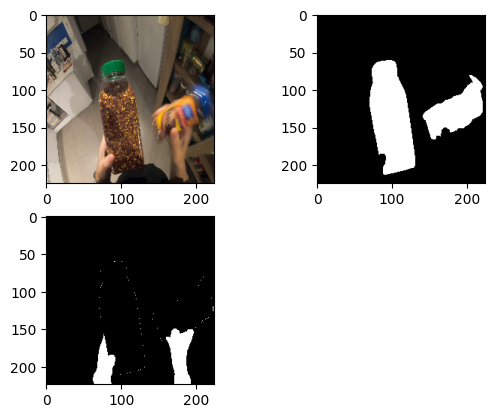

In [12]:
frames, labels, info = next(dataloader)
iter_counter += 1
# convert [batch, channel, height, width]
# to [batch, height, width, channel] for showing
img = frames.permute(0,2,3,1)[0]
mask = labels[0]

print(
    f"iter counter: {iter_counter}",
    f"frames shape: {frames.shape}",
    f"label shape: {labels.shape}",
    f"converted frames shape: {img.shape}",
    f"file name: {info}",
    sep="\n",
)

fig = plt.figure()

fig.add_subplot(2, 2, 1)
plt.imshow(img)

for cls in range(len(mask)):
    fig.add_subplot(2, 2, 2+cls)
    plt.imshow(mask[cls])
    plt.gray()

plt.show()

plt.clf()
plt.close()

## Semantic segmenting

In [7]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet101",
    encoder_weights="imagenet",
    in_channels=3,
    classes=2,
    # activation="sigmoid",
)

path = "objectness_classification/logs/lightning_logs/2023-04-18T01:10:25.004901/unet.pth"
model_path = os.path.join(git_root, path)
model.load_state_dict(
    torch.load(model_path, map_location=torch.device('cpu')),
    # strict=False,
)
model.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

model input shape: torch.Size([1, 3, 224, 224])
model output shape: (2, 224, 224)
binary map threshold: 0.5


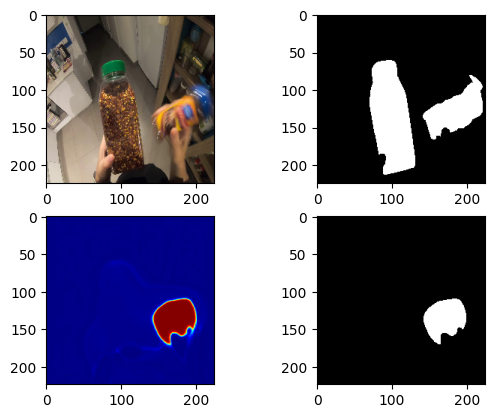

In [13]:
import numpy as np
import cv2

threshold = 0.5

input = frames.float()
with torch.no_grad():
    output = model(input)
output = output.sigmoid()
output = output.detach().numpy()[0]

print(
    f"model input shape: {input.shape}",
    f"model output shape: {output.shape}",
    f"binary map threshold: {threshold}",
    sep="\n",
)

fig = plt.figure()

fig.add_subplot(2, 2, 1)
plt.imshow(img)

fig.add_subplot(2, 2, 2)
plt.imshow(mask[0])
plt.gray()

for cls in range(len(output)):
    fig.add_subplot(2, 2, 3+cls)
    heatmap = cv2.applyColorMap(
        (output[cls] * 255).astype(np.uint8),
        cv2.COLORMAP_JET,
    )
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    plt.imshow(heatmap)

    fig.add_subplot(2, 2, 3+cls+1)
    binary_mask = output[cls] > threshold
    plt.imshow(binary_mask)
    plt.gray()

    break

plt.show()

plt.clf()
plt.close()

## Heatmap of encoder

input shape: torch.Size([1, 3, 224, 224])
non-trained resnet output shape: torch.Size([1, 1000])
resnet output shape: torch.Size([1, 1000])
Argmax of output: 811 811


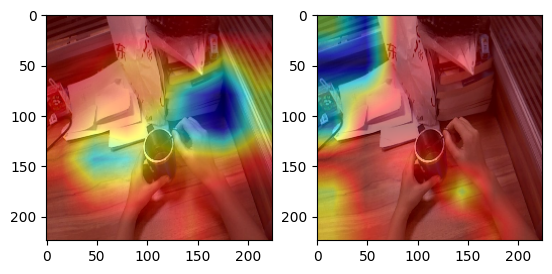

In [211]:
import numpy as np
import cv2
import torchvision.models as models
from torchcam.methods import GradCAM

# find argmax of non-trained model prediction
nt_resnet = models.resnet101(weights='DEFAULT')
nt_resnet.eval()

nt_cam_extractor = GradCAM(nt_resnet)

nt_out = nt_resnet(input)
class_idx = nt_out.squeeze(0).argmax().item()

# apply trained weight to model
param = torch.load(model_path, map_location=torch.device('cpu'))#["state_dict"]
new_param = {}
for k in param.keys():
    # if "model.unet.encoder" in k:
    if "encoder" in k:
        new_param[k[8:]] = param[k]

resnet = models.resnet101(weights='DEFAULT')
resnet.load_state_dict(new_param, strict=False)
resnet.eval()

cam_extractor = GradCAM(resnet)

out = resnet(input)
class_idx2 = nt_out.squeeze(0).argmax().item()

print(
    f"input shape: {input.shape}",
    f"non-trained resnet output shape: {nt_out.shape}",
    f"resnet output shape: {out.shape}",
    f"Argmax of output: {class_idx} {class_idx2}",
    sep="\n",
)

# function to create heatmap from given CAMs
def create_heatmap(cams):
    for cam in cams:
        map = cam.squeeze(0).numpy()

        map_min = np.min(map)
        map_max = np.max(map)
        map = (map - map_min)/(map_max - map_min)

        map = cv2.resize(map, (224,224))
        map = (map*255).astype(np.uint8)

        heatmap = cv2.applyColorMap(map, cv2.COLORMAP_JET)
        output = heatmap * 0.5 + img.detach().numpy() * 0.5 * 255

    return output

# show heatmaps of CAM
nt_heatmap = create_heatmap(nt_cam_extractor(class_idx, nt_out))
heatmap = create_heatmap(cam_extractor(class_idx2, out))

fig = plt.figure()

fig.add_subplot(1, 2, 1)
plt.imshow(nt_heatmap.astype(np.uint8))

fig.add_subplot(1, 2, 2)
plt.imshow(heatmap.astype(np.uint8))

plt.show()

plt.clf()
plt.close()
